In [1]:
import hashlib

from pathlib import Path

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
""" demo.py """
import re

from IPython import get_ipython

MULTILINE_PATTERN = re.compile(r"('\(.*?\)')", re.DOTALL)

def inline_match(match):
    return ' '.join(match.group(1).split())

# Replace multiline command argument strings with single-line version
def inline_multiline_command(lines):
    return [line + '\n' for line in
        MULTILINE_PATTERN.sub(inline_match, '\n'.join(lines)).split('\n')
    if len(line) > 0]

get_ipython().input_transformers_cleanup.append(inline_multiline_command)


=========================== Simulation Configuration ===========================

(
    speciation: 0.001,
    sample: Sample(
        percentage: 1.0,
        origin: Habitat,
        mode: Genesis,
    ),
    pause: None,
    rng: Seed(42),
    scenario: WrappingNoise(
        seed: 42,
        coverage: 0.6,
        scale: 0.07,
        persistence: 0.5,
        octaves: 8,
        sample: Extent(
            x: 0,
            y: 0,
            width: 100,
            height: 100,
        ),
        sigma: 1.0,
    ),
    algorithm: Independent(
        delta_t: 2.0,
        step_slice: 10,
        dedup_cache: Relative(
            factor: 1.0,
        ),
        parallelism_mode: Monolithic(
            event_slice: Relative(
                factor: 2.0,
            ),
        ),
    ),
    partitioning: Monolithic(),
    log: None,
    reporters: [
        Plugin(
            library: "target/debug/deps/libnecsim_plugins_common.so",
            reporters: [
                Progr

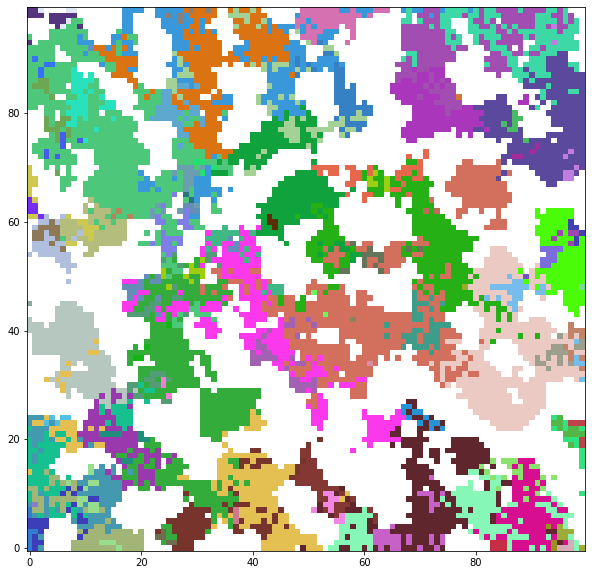

In [3]:
Path("species.ft").unlink(missing_ok=True)

!target/debug/rustcoalescence simulate '(
    speciation: 0.001,
    sample: Sample(percentage: 1.0),
    rng: Seed(42),
    
    algorithm: Independent(),

    scenario: WrappingNoise(
        seed: 42,
        scale: 0.07,
        persistence: 0.5,
        octaves: 8,
        coverage: 0.6,
        sample: Extent(x: 0, y: 0, width: 100, height: 100),
        sigma: 1.0,
    ),
    
    reporters: [
        Plugin(
            library: "target/debug/deps/libnecsim_plugins_common.so",
            reporters: [Progress(), Execution(), Biodiversity()],
        ),
        Plugin(
            library: "target/debug/deps/libnecsim_plugins_species.so",
            reporters: [IndividualSpeciesFeather(output: "species.ft")],
        ),
    ],
)'

df = pd.read_feather("species.ft")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

X, Y = np.meshgrid(np.arange(-0.5, 100.5, 1), np.arange(-0.5, 100.5, 1), indexing='xy')

species = { None: 0 }
colours = [(1,1,1)]

Z = np.zeros(shape=(100, 100), dtype=int)

for _, e in df.iterrows():
    ns = species.get(e["species"])
    
    if ns is None:
        ns = len(species)
        species[e["species"]] = ns
        
        h = hashlib.sha3_512()
        h.update(e["species"])
        r, g, b = h.digest()[:3]
        
        colours.append((r/255,g/255,b/255))
    
    Z[e["y"], e["x"]] = ns

ax.pcolormesh(X, Y, Z, shading='flat', cmap=mpl.colors.LinearSegmentedColormap.from_list("mycmap", colours))

plt.show()